# Connecting Google Drive and import necessary libraries


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install python-chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import chess.pgn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import chess
from networkx.algorithms import bipartite
import itertools

# open file and read into df

In [5]:
pgn_file = open("/content/drive/My Drive/lichess4545-all-s01-33.pgn")
game = chess.pgn.read_game(pgn_file)

data = []

while game:
    headers = game.headers
    
    eco = headers.get("ECO", "NoECO")  # Use the get() method to get the value of "ECO", or return "NoECO" if it doesn't exist
    data.append({
        "Date": headers["Date"],
        "White": headers["White"],
        "Black": headers["Black"],
        "WhiteElo": headers["WhiteElo"],
        "BlackElo": headers["BlackElo"],
        "ECO": eco,  # Use the value of ECO variable
        "Result": headers["Result"],
    })
    
    game = chess.pgn.read_game(pgn_file)

df = pd.DataFrame(data)

In [6]:
df

,Date,White,Black,WhiteElo,BlackElo,ECO,Result
0,2015.11.01,JTate,theino,1796,1868,E11,1-0
1,2015.11.01,sprite143,MrLegilimens,1648,1602,A46,1/2-1/2
2,2015.11.01,buubble,icendoan,1400,1548,B01,0-1
3,2015.11.01,zezetel,Baybars,1608,1554,B77,0-1
4,2015.10.31,CheapEndgameTricks,mkoga,1654,1754,B12,0-1
...,...,...,...,...,...,...,...
31183,2023.01.24,b_elyay,NLance,2062,2070,C67,0-1
31184,2023.01.23,M0r1,Astronominoff,1985,1996,B00,0-1
31185,2023.01.23,pafiedor,glbert,1857,1895,D11,1-0
31186,2023.01.23,izcms02,aerdna69,1878,1886,D30,1-0


## Reverse dataframe

Reversed dataframe because the last Elo scores will be taken into account when creating the network.

In [7]:
df = df.iloc[::-1]
df

,Date,White,Black,WhiteElo,BlackElo,ECO,Result
31187,2023.01.23,Poldi_der_Drache,mo_mo,2006,1975,B01,0-1
31186,2023.01.23,izcms02,aerdna69,1878,1886,D30,1-0
31185,2023.01.23,pafiedor,glbert,1857,1895,D11,1-0
31184,2023.01.23,M0r1,Astronominoff,1985,1996,B00,0-1
31183,2023.01.24,b_elyay,NLance,2062,2070,C67,0-1
...,...,...,...,...,...,...,...
4,2015.10.31,CheapEndgameTricks,mkoga,1654,1754,B12,0-1
3,2015.11.01,zezetel,Baybars,1608,1554,B77,0-1
2,2015.11.01,buubble,icendoan,1400,1548,B01,0-1
1,2015.11.01,sprite143,MrLegilimens,1648,1602,A46,1/2-1/2


## Check the classes of objects

When we look at the table below, we can see that Elo scores are kept as strings. We need to convert these scores to integers.

In [8]:
print(df.applymap(type))

                Date          White          Black       WhiteElo  \
31187  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31186  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31185  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31184  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
31183  <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
...              ...            ...            ...            ...   
4      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
3      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
2      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
1      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   
0      <class 'str'>  <class 'str'>  <class 'str'>  <class 'str'>   

            BlackElo            ECO         Result  
31187  <class 'str'>  <class 'str'>  <class 'str'>  
31186  <class 'str'>  <class 'str'>  <class 'str'>  
31185  <clas

In [9]:
df['WhiteElo'] = df['WhiteElo'].astype(int)
df['BlackElo'] = df['BlackElo'].astype(int)

## Number of NoECOs in the dataframe

In [10]:
count_no_opening = df[df['ECO'] == 'NoECO'].shape[0]
print("Number of 'NoECO's:", count_no_opening)

Number of 'NoECO's: 0


Each game has the information of "ECO", therefore there is no need to exclude any game from the dataset.

## Examine the data

There are 3498 players in the dataset:

In [11]:
players = pd.concat([df['White'], df['Black']]).unique()
print(len(players))

3498


There are 473 openings:

In [12]:
openings = df["ECO"].unique()
print(len(openings))

473


In [13]:
print(df["ECO"].unique())

['B01' 'D30' 'D11' 'B00' 'C67' 'B12' 'A45' 'B33' 'B21' 'B30' 'A04' 'D00'
 'E12' 'A01' 'C82' 'E04' 'C01' 'D85' 'C47' 'B22' 'C74' 'B10' 'B27' 'E77'
 'D01' 'E38' 'B15' 'C51' 'C55' 'C45' 'D31' 'D15' 'A37' 'C60' 'C00' 'C88'
 'B99' 'B06' 'B13' 'D92' 'A84' 'D10' 'B36' 'B51' 'A96' 'C69' 'C65' 'D35'
 'C02' 'A10' 'D45' 'A48' 'C24' 'A57' 'D91' 'A20' 'E61' 'D87' 'C77' 'A02'
 'C53' 'C43' 'C33' 'E49' 'C46' 'B32' 'A09' 'C42' 'A40' 'B14' 'D37' 'A14'
 'D02' 'A35' 'B31' 'C92' 'D43' 'E06' 'A18' 'D20' 'A23' 'B46' 'B48' 'E35'
 'C36' 'B38' 'B90' 'C28' 'B94' 'D78' 'D41' 'E73' 'A05' 'B23' 'E01' 'B20'
 'B40' 'B35' 'B02' 'B44' 'D05' 'E14' 'E94' 'A22' 'A58' 'B69' 'E30' 'C06'
 'B25' 'D59' 'E15' 'D04' 'A06' 'C21' 'C44' 'C50' 'B08' 'C25' 'E20' 'A00'
 'C10' 'B39' 'A36' 'D21' 'A16' 'C29' 'D40' 'D34' 'B11' 'A30' 'C09' 'B03'
 'C80' 'A80' 'B24' 'B07' 'D07' 'A07' 'D96' 'B17' 'E19' 'E48' 'B50' 'B56'
 'A68' 'D81' 'C26' 'C87' 'B42' 'D50' 'D80' 'C63' 'D44' 'E43' 'E11' 'C15'
 'E46' 'C05' 'A31' 'D13' 'E64' 'A85' 'D27' 'D32' 'B

In [14]:

elo_ranges = [(800, 1200), (1201, 1600), (1601, 2000), (2001, 2400)]

for elo_range in elo_ranges:
    count = (((df['WhiteElo'] >= elo_range[0]) & (df['WhiteElo'] <= elo_range[1])) \
          | ((df['BlackElo'] >= elo_range[0]) & (df['BlackElo'] <= elo_range[1])) \
          ).sum()
    print(f"Number of players with Elo between {elo_range[0]} and {elo_range[1]}: {count}")

Number of players with Elo between 800 and 1200: 273
Number of players with Elo between 1201 and 1600: 5027
Number of players with Elo between 1601 and 2000: 21020
Number of players with Elo between 2001 and 2400: 8896


In [15]:
df['WhiteElo'] = df['WhiteElo'].astype(int)
df['BlackElo'] = df['BlackElo'].astype(int)

max_white_elo = df['WhiteElo'].max()
print(f"Maximum WhiteElo: {max_white_elo}")
min_white_elo = df['WhiteElo'].min()
print(f"Minimum WhiteElo: {min_white_elo}")

Maximum WhiteElo: 2549
Minimum WhiteElo: 802


In [16]:
df['BlackElo'] = df['BlackElo'].astype(int)

max_black_elo = df['BlackElo'].max()
print(f"Maximum BlackElo: {max_black_elo}")

min_black_elo = df['BlackElo'].min()
print(f"Minimum BlackElo: {min_black_elo}")

Maximum BlackElo: 2641
Minimum BlackElo: 806


# Create Network

## Bipartite Opening - Player Network

In [17]:
B = nx.Graph()

# Add nodes with the player attribute "bipartite=0", and attribute label="player"
B.add_nodes_from(df['White'].unique(), bipartite=0, label='player', elo=0)
B.add_nodes_from(df['Black'].unique(), bipartite=0, label='player', elo=0)

# Add nodes with the opening attribute "bipartite=1", and attribute label="ECO"
B.add_nodes_from(df['ECO'].unique(), bipartite=1, label='ECO', ECOtype=None,
                 elo_800_1200=0, elo_1201_1600=0, elo_1601_2000=0, elo_2001_2400=0)

# Add edges between players and openings
for index, row in df.iterrows():
    white_player, black_player, opening = row['White'], row['Black'], row['ECO']
    white_elo, black_elo = row['WhiteElo'], row['BlackElo']
    
    # White player
    if B.has_edge(white_player, opening):
        B[white_player][opening]['weight'] += 1
    else:
        B.add_edge(white_player, opening, weight=1)
    
    # Black player
    if B.has_edge(black_player, opening):
        B[black_player][opening]['weight'] += 1
    else:
        B.add_edge(black_player, opening, weight=1)

    # Update Elo scores if they are equal to 0
    if B.nodes[white_player]['elo'] == 0:
        B.nodes[white_player]['elo'] = white_elo
    if B.nodes[black_player]['elo'] == 0:
        B.nodes[black_player]['elo'] = black_elo
    
    # Update ECOtype attribute within the loop
    if B.nodes[opening]['ECOtype'] is None:
        B.nodes[opening]['ECOtype'] = opening[0]

    # Update the ECO node attributes based on the Elo ratings of the players
    for player_elo in [white_elo, black_elo]:
        if 800 <= player_elo <= 1200:
            B.nodes[opening]['elo_800_1200'] += 1
        elif 1201 <= player_elo <= 1600:
            B.nodes[opening]['elo_1201_1600'] += 1
        elif 1601 <= player_elo <= 2000:
            B.nodes[opening]['elo_1601_2000'] += 1
        elif 2001 <= player_elo <= 2400:
            B.nodes[opening]['elo_2001_2400'] += 1

In [18]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(B))  # Supposed to be True

True


In [19]:
nx.write_gexf(B, "/content/drive/My Drive/BiperGraph.gexf", encoding='utf-8')

## Project players from the graph

In [20]:
# Project the player nodes from the bipartite graph
player_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 0}
player_projected_graph = nx.bipartite.projected_graph(B, player_nodes)

In [21]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(player_projected_graph))  # Supposed to be False

False


In [22]:
nx.write_gexf(player_projected_graph, "/content/drive/My Drive/PlayerProjectedGraph.gexf", encoding='utf-8')

## Project ECOs from the Graph

In [23]:
# Project the ECO nodes from the bipartite graph
ECO_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 1}
ECO_projected_graph = nx.bipartite.projected_graph(B, ECO_nodes)

In [24]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(ECO_projected_graph))  # Supposed to be False

False


In [25]:
nx.write_gexf(ECO_projected_graph, "/content/drive/My Drive/OpeningProjectedGraph.gexf", encoding='utf-8')

## Projection of openings based on ECO Type (A/B/C/D/E)

In [ ]:
ECO_projected_graphs = {}

for eco_type in ['A', 'B', 'C', 'D', 'E']:
    # Filter ECO nodes with the given ECOtype
    filtered_ECO_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 1 and data['ECOtype'] == eco_type}
    
    # Project the filtered ECO nodes from the bipartite graph
    ECO_projected_graph = nx.bipartite.projected_graph(B, filtered_ECO_nodes)
    
    # Save the projected graph to the dictionary with the key as the ECOtype
    ECO_projected_graphs[eco_type] = ECO_projected_graph

# Save each ECO type projection to a separate variable
ECO_A_projected_graph = ECO_projected_graphs['A']
ECO_B_projected_graph = ECO_projected_graphs['B']
ECO_C_projected_graph = ECO_projected_graphs['C']
ECO_D_projected_graph = ECO_projected_graphs['D']
ECO_E_projected_graph = ECO_projected_graphs['E']


In [ ]:
# Check if the graph is bipartite
print(nx.bipartite.is_bipartite(ECO_A_projected_graph))  # Supposed to be False

False


In [ ]:
nx.write_gexf(ECO_A_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_A.gexf", encoding='utf-8')
nx.write_gexf(ECO_B_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_B.gexf", encoding='utf-8')
nx.write_gexf(ECO_C_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_C.gexf", encoding='utf-8')
nx.write_gexf(ECO_D_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_D.gexf", encoding='utf-8')
nx.write_gexf(ECO_E_projected_graph, "/content/drive/My Drive/OpeningProjectedGraphTYPE_E.gexf", encoding='utf-8')

## Projection of Players based on Elo Ratings (800-1200/1201-1600/1601-2000/2001-2400)

In [ ]:
player_projected_graphs = {}

elo_ranges = [
    (800, 1200),
    (1201, 1600),
    (1601, 2000),
    (2001, 2400),
]

for elo_range in elo_ranges:
    min_elo, max_elo = elo_range

    # Filter player nodes within the given Elo range
    filtered_player_nodes = {node for node, data in B.nodes(data=True) if data['bipartite'] == 0 and min_elo <= data['elo'] <= max_elo}
    
    # Project the filtered player nodes from the bipartite graph
    player_projected_graph = nx.bipartite.projected_graph(B, filtered_player_nodes)
    
    # Save the projected graph to the dictionary with the key as the Elo range
    player_projected_graphs[elo_range] = player_projected_graph

# Save each Elo range projection to a separate variable
players_800_1200_projected_graph = player_projected_graphs[(800, 1200)]
players_1201_1600_projected_graph = player_projected_graphs[(1201, 1600)]
players_1601_2000_projected_graph = player_projected_graphs[(1601, 2000)]
players_2001_2400_projected_graph = player_projected_graphs[(2001, 2400)]

In [ ]:
nx.write_gexf(players_800_1200_projected_graph, "/content/drive/My Drive/players_800_1200_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_1201_1600_projected_graph, "/content/drive/My Drive/players_1201_1600_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_1601_2000_projected_graph, "/content/drive/My Drive/players_1601_2000_projected_graph.gexf", encoding='utf-8')
nx.write_gexf(players_2001_2400_projected_graph, "/content/drive/My Drive/players_2001_2400_projected_graph.gexf", encoding='utf-8')

# Analysis

## Bipartite Network Analysis

In [26]:
#Number of nodes
print("Number of nodes: ", len(B.nodes()))

#Number of edges
print("Number of edges: ", len(B.edges()))

#Centrality Measurement of All Network
centralities = {"Betweenness": nx.betweenness_centrality , "Closeness":nx.closeness_centrality, "Degree":nx.degree_centrality}

for k,v in centralities.items():

  result = list(v(B).items())
  result.sort(key = lambda i:i[1], reverse = True)
  print(f"{k} centrality measurement (Top 10): ", result[:10])

Number of nodes:  3971
Number of edges:  43726
Betweenness centrality measurement (Top 10):  [('B12', 0.06782094836725362), ('A45', 0.06540217229245208), ('B01', 0.06533427819802616), ('D00', 0.05355336346635687), ('B22', 0.0434557763164762), ('D02', 0.0432732541782358), ('B23', 0.03903830757462569), ('B10', 0.03220567922257446), ('B90', 0.030828719265035495), ('D35', 0.02905686757020238)]
Closeness centrality measurement (Top 10):  [('Scarff', 0.4627578971908148), ('glbert', 0.4555364314400459), ('adande1', 0.4528344929850576), ('yago666', 0.44843555856771716), ('freddy267t', 0.44682048396173324), ('jsettle1', 0.44611754129677494), ('bufferunderrun', 0.44372415334749077), ('Forhavu', 0.44342678431810567), ('mynameismund', 0.4427344708375153), ('Kraaft', 0.4423398328690808)]
Degree centrality measurement (Top 10):  [('B12', 0.21032745591939547), ('A45', 0.2047858942065491), ('B01', 0.19848866498740553), ('D00', 0.18387909319899243), ('D02', 0.16473551637279596), ('B22', 0.1624685138539

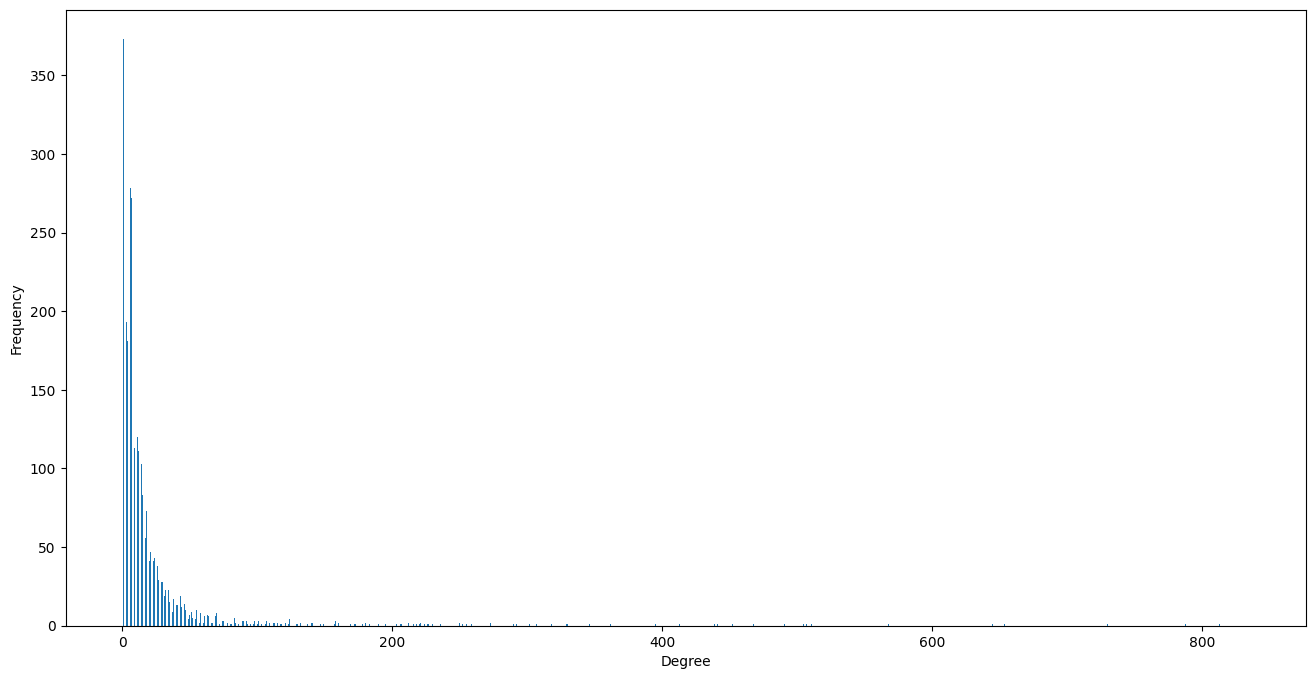

In [27]:
#Degree distribution of network
degree_freq = nx.degree_histogram(B)
degrees = range(len(degree_freq))
plt.figure(figsize=(16, 8)) 
plt.bar(degrees, degree_freq, width=0.5) 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

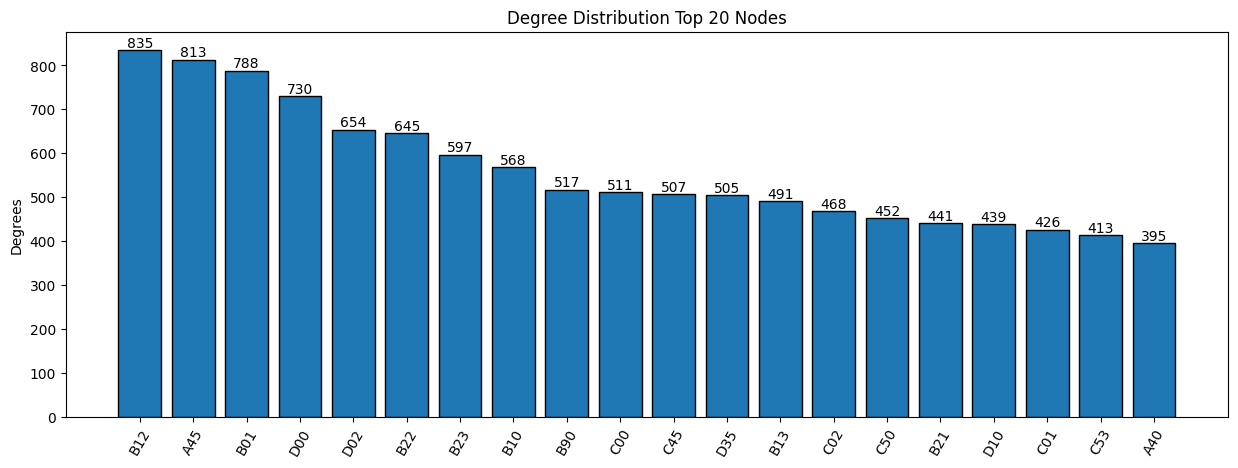

In [28]:
#Degree distribution of network top 20
nodeDegrees = [(n,d) for n,d in B.degree()]
nodeDegrees.sort(key = lambda x: x[1], reverse=True)
degrees = [d for n,d in nodeDegrees[:20]]
labels = [n for n,d in nodeDegrees[:20]]

fig, ax = plt.subplots(figsize=(15, 5))
bar_container = ax.bar(labels, degrees, edgecolor = 'black')
ax.set(ylabel='Degrees', title='Degree Distribution Top 20 Nodes')
ax.bar_label(bar_container)
plt.xticks(rotation=60)
fig.show()

In [29]:
#Clustering and density analysis of network
print("Average clustering of network: ", nx.average_clustering(B))

clusteringCoefficients = list(nx.clustering(B).items())
clusteringCoefficients.sort(key = lambda i:i[1], reverse = True)
print("Clustering Coefficients (Top 20): ", clusteringCoefficients[:10])

print(f"Density of network: {nx.density(B)}\n")

Average clustering of network:  0.0
Clustering Coefficients (Top 20):  [('Poldi_der_Drache', 0), ('izcms02', 0), ('pafiedor', 0), ('M0r1', 0), ('b_elyay', 0), ('ElChivo', 0), ('cyclop3000', 0), ('CrazyMerlyn', 0), ('chessfefe', 0), ('val1313', 0)]
Density of network: 0.005547270608638067



In [30]:
#Assortativeness analysis of network
print(f"Degree assortativity of network: {nx.degree_assortativity_coefficient(B)}\n")
print(f"Degree pearson correlation coefficient of graph: {nx.degree_pearson_correlation_coefficient(B)}\n")

#Degree connectivity of network
print(f"Average degree connectivity of graph: {nx.average_degree_connectivity(B)}\n")

#Average neighbor degree of network
nodesNeighborDegree = list(nx.average_neighbor_degree(B).items())
nodesNeighborDegree.sort(key = lambda i:i[1], reverse = True)
print(f"The average degree of the neighborhood of nodes (Top 10): ", nodesNeighborDegree[:10])

Degree assortativity of network: -0.3991923577938074

Degree pearson correlation coefficient of graph: -0.3991923577938078

Average degree connectivity of graph: {18: 270.6605783866058, 36: 225.28306878306879, 9: 287.6558505408063, 55: 172.1981818181818, 11: 280.5181818181818, 5: 331.28977272727275, 12: 269.0307807807808, 3: 328.3419689119171, 74: 224.01351351351352, 29: 242.564039408867, 39: 171.24358974358975, 8: 287.25053879310343, 33: 203.85173160173161, 85: 219.2941176470588, 10: 287.3677685950413, 70: 122.45535714285714, 32: 193.71059782608697, 34: 213.3785166240409, 25: 237.78266666666667, 22: 245.33373205741626, 62: 192.7741935483871, 24: 247.3498062015504, 59: 143.01016949152543, 20: 248.74024390243903, 6: 300.54376498800957, 26: 231.15080971659918, 47: 225.10638297872342, 56: 144.03896103896105, 45: 217.36111111111111, 48: 176.1279761904762, 37: 233.32732732732734, 27: 251.03065134099617, 19: 262.99342105263156, 41: 204.1782363977486, 7: 292.18644957983196, 4: 293.70856353591

In [31]:
#Distance measures of network  
print(f"Radius: {nx.radius(B)}\n")              #The radius is the minimum eccentricity
print(f"Diameter: {nx.diameter(B)}\n")          #The diameter is the maximum eccentricity
print(f"Eccentricity: {nx.eccentricity(B)}\n")  #The eccentricity of a node v is the maximum distance from v to all other nodes in G
print(f"Center: {nx.center(B)}\n")              #The center is the set of nodes with eccentricity equal to radius
print(f"Periphery: {nx.periphery(B)}\n")        #The periphery is the set of nodes with eccentricity equal to the diameter

Radius: 4

Diameter: 6

Eccentricity: {'Poldi_der_Drache': 5, 'izcms02': 4, 'pafiedor': 5, 'M0r1': 4, 'b_elyay': 5, 'ElChivo': 4, 'cyclop3000': 5, 'CrazyMerlyn': 5, 'chessfefe': 5, 'val1313': 4, 'keeto': 4, 'Wealth_and_Taste': 5, 'xkm': 4, 'chatakkuma': 4, 'eXoF1343': 5, 'jk_182': 4, 'yago666': 4, 'Aka4053602': 5, 'jwwells42': 4, 'Moccy': 4, 'wilfj': 4, 'nvasquez': 4, 'SlowChess73': 5, 'u12912': 5, 'Razorneck': 4, 'imikacic': 4, 'Silkthewanderer': 4, 'danbock': 4, 'TheVacuousRom': 5, 'ben3536': 5, 'Akibart': 5, 'awfulmove': 5, 'danimal_t': 5, 'SundanceXLC': 4, 'osrswoodcutting': 4, 'JeoffMorris': 5, 'Constant1n': 4, 'supertoby': 4, 'destroyer11758': 5, 'ipr': 4, 'pioki': 4, 'Nairwolf': 4, 'nerja25390': 4, 'BamaBeeblebrox': 4, 'The_Red_Joker': 4, 'Sidewinder1648': 5, 'Kry1001': 4, 'mgold': 4, 'rjhoro': 5, 'boinetnicolas': 5, 'p_s_q': 5, 'BMAstatine': 5, 'BigPig93': 5, 'cristoper': 4, 'Unbreakable-1': 5, 'rapiplay': 4, 'blindAdrenaline': 5, 'RSInternecio': 5, 'Mediocratic': 5, 'Macalda':

## Bipartite Network Analysis (ECO's projected)

In [32]:
#Check if graph is connected or not
isConnected = nx.is_connected(ECO_projected_graph)
isConnected

True

In [33]:
#Number of nodes
print("Number of nodes: ", len(ECO_projected_graph.nodes()))

#Number of edges
print("Number of edges: ", len(ECO_projected_graph.edges()))

#Centrality Measurement of All Network
centralities = {"Betweenness": nx.betweenness_centrality , "Closeness":nx.closeness_centrality, "Degree":nx.degree_centrality}

for k,v in centralities.items():

  result = list(v(ECO_projected_graph).items())
  result.sort(key = lambda i:i[1], reverse = True)
  print(f"{k} centrality measurement (Top 10): ", result[:10])

Number of nodes:  473
Number of edges:  68019
Betweenness centrality measurement (Top 10):  [('B01', 0.005012449364835447), ('D00', 0.004291966193919322), ('B22', 0.00427565896697468), ('B12', 0.004079811511934476), ('B23', 0.0038828291268179363), ('D02', 0.0038396150276986175), ('A45', 0.003607399317045093), ('C00', 0.0035158593360954224), ('D35', 0.0035055593992990423), ('D37', 0.0034921942612665684)]
Closeness centrality measurement (Top 10):  [('B12', 0.9672131147540983), ('B01', 0.9672131147540983), ('B22', 0.9652351738241309), ('D00', 0.9613034623217923), ('D02', 0.959349593495935), ('A45', 0.9574036511156186), ('D35', 0.9535353535353536), ('B23', 0.9458917835671342), ('D10', 0.944), ('C00', 0.944)]
Degree centrality measurement (Top 10):  [('B12', 0.9661016949152542), ('B01', 0.9661016949152542), ('B22', 0.9639830508474576), ('D00', 0.9597457627118644), ('D02', 0.9576271186440678), ('A45', 0.9555084745762712), ('D35', 0.951271186440678), ('B23', 0.9427966101694916), ('D10', 0.94

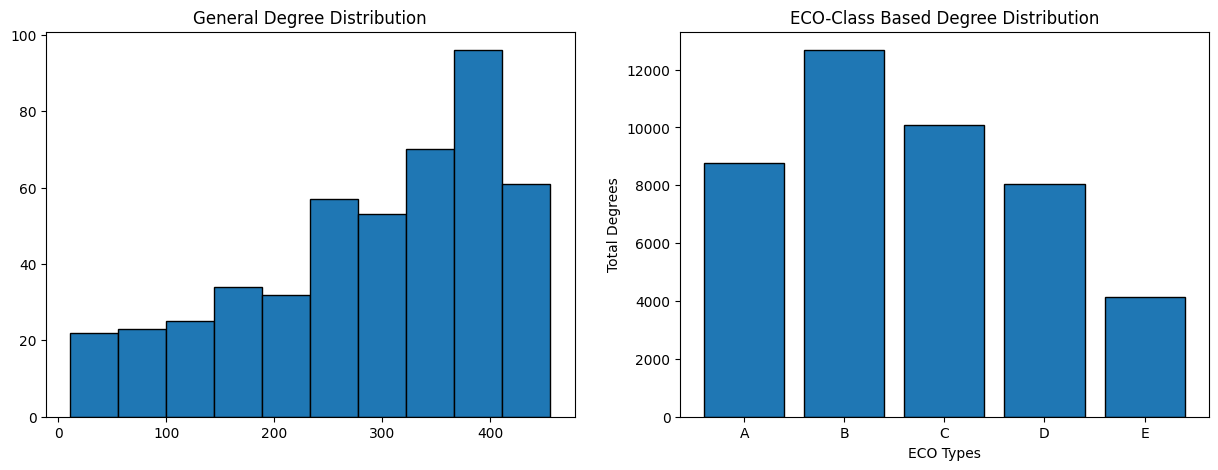

In [35]:
fig = plt.figure(figsize=(15,5))

#General degree distribution
plt.subplot(1, 2, 1)
plt.title("General Degree Distribution")
degrees = [d for n,d in ECO_projected_graph.degree()]
plt.hist([d for n,d in ECO_projected_graph.degree()], edgecolor = 'black' )

#Degree distribution of ECO Types

ecoDegrees = {'A':0 ,'B':0 , 'C':0, 'D':0, 'E':0}
openingNodes = [x for x,y in ECO_projected_graph.nodes(data=True)]
for n,d in B.degree():
  if n in openingNodes:
    ecoDegrees[n[0]] += d

plt.subplot(1, 2, 2)
plt.title("ECO-Class Based Degree Distribution") 
plt.bar(range(len(ecoDegrees)), list(ecoDegrees.values()), tick_label=list(ecoDegrees.keys()), edgecolor = 'black')
plt.xlabel("ECO Types")
plt.ylabel("Total Degrees")
plt.show()

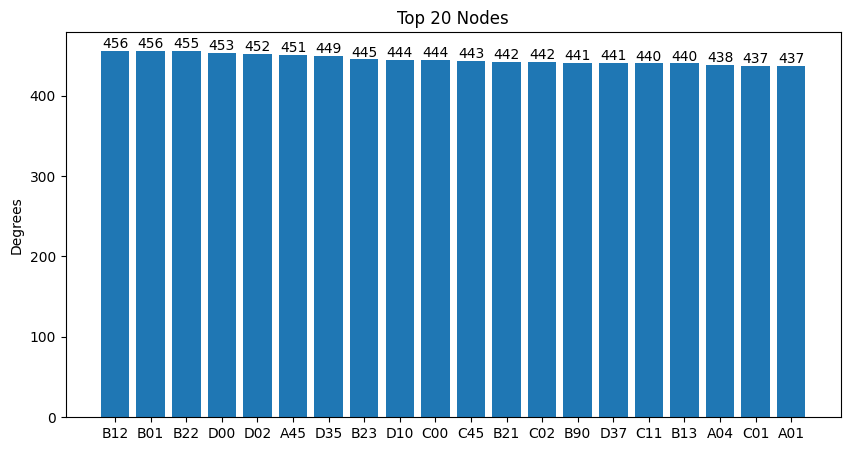

In [36]:
#Degree distribution of network top 20
nodeDegrees = [(n,d) for n,d in ECO_projected_graph.degree()]
nodeDegrees.sort(key = lambda x: x[1], reverse=True)
degrees = [d for n,d in nodeDegrees[:20]]
labels = [n for n,d in nodeDegrees[:20]]

fig, ax = plt.subplots(figsize=(10, 5))
bar_container = ax.bar(labels, degrees)
ax.set(ylabel='Degrees', title='Top 20 Nodes')
ax.bar_label(bar_container)
fig.show()

Average clustering of network:  0.8454251290889827
Density of network: 0.609336367219694



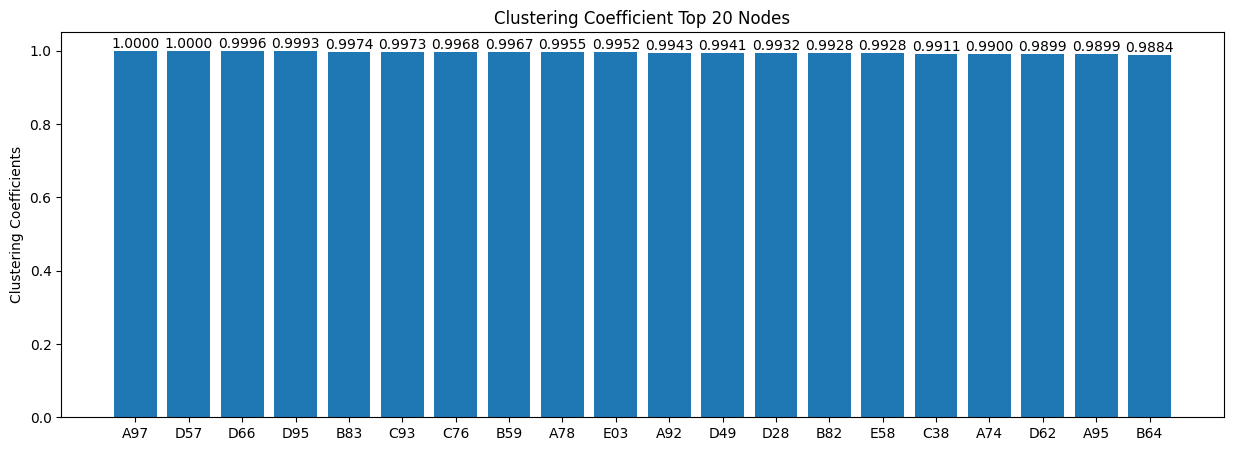

In [37]:
#Clustering and density analysis of network
print("Average clustering of network: ", nx.average_clustering(ECO_projected_graph))
print(f"Density of network: {nx.density(ECO_projected_graph)}\n")

clusteringCoefficients = list(nx.clustering(ECO_projected_graph).items())
clusteringCoefficients.sort(key = lambda i:i[1], reverse = True)
labels = [n for n,c in clusteringCoefficients[:20]]
coefficients = [c for n,c in clusteringCoefficients[:20]]

fig, ax = plt.subplots(figsize=(15, 5))
bar_container = ax.bar(labels, coefficients)
ax.set(ylabel='Clustering Coefficients', title='Clustering Coefficient Top 20 Nodes')
ax.bar_label(bar_container, fmt='{:,.4f}')
fig.show()


Degree assortativity of network: -0.23434530288110372

Degree pearson correlation coefficient of graph: -0.2343453028810929

Average degree connectivity of graph: {306: 343.81045751633985, 430: 308.1860465116279, 329: 336.8936170212766, 429: 308.0058275058275, 415: 313.15301204819275, 357: 331.765639589169, 184: 370.26630434782606, 315: 340.93333333333334, 137: 387.985401459854, 219: 365.80365296803654, 79: 377.9810126582278, 335: 339.2636815920398, 235: 362.0404255319149, 363: 329.45454545454544, 328: 340.8323170731707, 144: 372.0763888888889, 104: 370.9230769230769, 271: 355.23542435424355, 379: 325.1833773087071, 385: 323.1636363636364, 407: 317.5257985257985, 347: 336.2247838616715, 158: 373.37974683544303, 243: 356.4691358024691, 307: 349.3778501628664, 392: 321.4948979591837, 268: 351.86442786069654, 411: 314.92761557177613, 352: 333.88825757575756, 62: 391.0806451612903, 242: 362.7809917355372, 142: 374.7535211267606, 147: 374.03854875283446, 375: 328.1533333333333, 340: 337.622

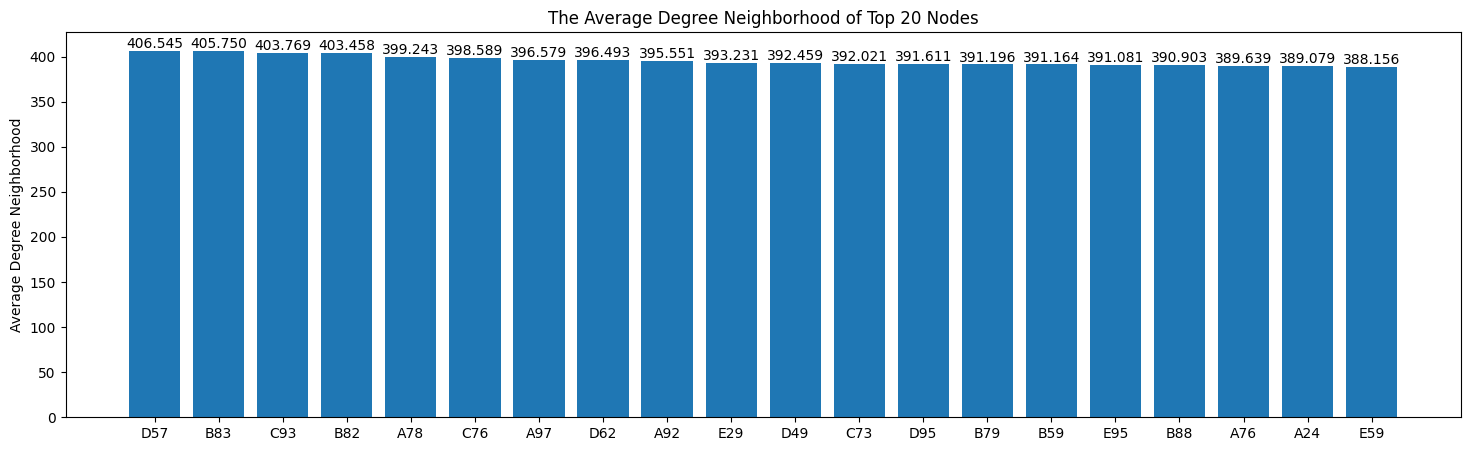

In [38]:
#Assortativeness analysis of network
print(f"Degree assortativity of network: {nx.degree_assortativity_coefficient(ECO_projected_graph)}\n")
print(f"Degree pearson correlation coefficient of graph: {nx.degree_pearson_correlation_coefficient(ECO_projected_graph)}\n")

#Degree connectivity of network
print(f"Average degree connectivity of graph: {nx.average_degree_connectivity(ECO_projected_graph)}\n")

#Average neighbor degree of network
nodesNeighborDegree = list(nx.average_neighbor_degree(ECO_projected_graph).items())
nodesNeighborDegree.sort(key = lambda i:i[1], reverse = True)
labels = [n for n,c in nodesNeighborDegree[:20]]
coefficients = [c for n,c in nodesNeighborDegree[:20]]

fig, ax = plt.subplots(figsize=(18, 5))
bar_container = ax.bar(labels, coefficients)
ax.set(ylabel='Average Degree Neighborhood', title='The Average Degree Neighborhood of Top 20 Nodes')
ax.bar_label(bar_container, fmt='{:,.3f}', fontsize = 10)
fig.show()

In [39]:
#Distance measures of network  
print(f"Radius: {nx.radius(ECO_projected_graph)}\n")              #The radius is the minimum eccentricity
print(f"Diameter: {nx.diameter(ECO_projected_graph)}\n")          #The diameter is the maximum eccentricity
print(f"Eccentricity: {nx.eccentricity(ECO_projected_graph)}\n")  #The eccentricity of a node v is the maximum distance from v to all other nodes in G
print(f"Center: {nx.center(ECO_projected_graph)}\n")              #The center is the set of nodes with eccentricity equal to radius
print(f"Periphery: {nx.periphery(ECO_projected_graph)}\n")        #The periphery is the set of nodes with eccentricity equal to the diameter

Radius: 2

Diameter: 3

Eccentricity: {'E47': 2, 'A15': 2, 'D97': 2, 'A46': 2, 'E10': 2, 'E62': 2, 'B26': 2, 'A88': 2, 'D75': 2, 'D39': 2, 'E84': 2, 'C68': 2, 'E22': 2, 'E91': 2, 'D47': 2, 'A69': 2, 'E45': 2, 'E24': 2, 'D04': 2, 'D38': 2, 'A22': 2, 'A38': 2, 'E07': 2, 'B49': 2, 'C92': 2, 'A84': 2, 'A81': 2, 'B06': 2, 'B53': 2, 'E95': 2, 'C20': 2, 'B86': 2, 'E89': 2, 'E46': 2, 'E92': 2, 'A25': 2, 'A32': 2, 'B44': 2, 'B27': 2, 'B55': 2, 'B39': 2, 'E19': 2, 'C73': 2, 'C32': 2, 'D76': 2, 'A62': 2, 'A31': 2, 'D82': 2, 'C16': 2, 'D50': 2, 'D96': 2, 'E34': 2, 'A34': 2, 'A45': 2, 'E85': 2, 'C61': 2, 'A83': 2, 'E08': 2, 'A51': 2, 'C62': 2, 'C82': 2, 'A71': 2, 'A70': 2, 'A48': 2, 'E38': 2, 'C08': 2, 'A68': 2, 'C66': 2, 'B21': 2, 'E74': 2, 'C97': 2, 'C03': 2, 'A61': 2, 'C18': 2, 'C30': 2, 'B09': 2, 'E23': 2, 'C74': 2, 'C28': 2, 'B56': 2, 'B54': 2, 'A05': 2, 'C76': 2, 'B11': 2, 'D70': 2, 'C36': 2, 'D73': 2, 'D17': 2, 'A21': 2, 'B62': 2, 'A40': 2, 'D05': 2, 'D43': 2, 'E90': 2, 'B48': 2, 'A91': 2, '

## Bipartite Network Analysis (Players projected)

In [40]:
#Check if graph is connected or not
isConnected = nx.is_connected(player_projected_graph)
isConnected

True

In [41]:
#Number of nodes
print("Number of nodes: ", len(player_projected_graph.nodes()))

#Number of edges
print("Number of edges: ", len(player_projected_graph.edges()))



# #Centrality Measurement of All Network
# centralities = {"Betweenness": nx.betweenness_centrality , "Closeness":nx.closeness_centrality, "Degree":nx.degree_centrality}

# for k,v in centralities.items():

#   result = list(v(player_projected_graph).items())
#   result.sort(key = lambda i:i[1], reverse = True)
#   print(f"{k} centrality measurement (Top 10): ", result[:10])


Number of nodes:  3498
Number of edges:  2708602


(array([295., 306., 329., 402., 541., 489., 452., 365., 239.,  80.]),
 array([   5. ,  333.8,  662.6,  991.4, 1320.2, 1649. , 1977.8, 2306.6,
        2635.4, 2964.2, 3293. ]),
 <BarContainer object of 10 artists>)

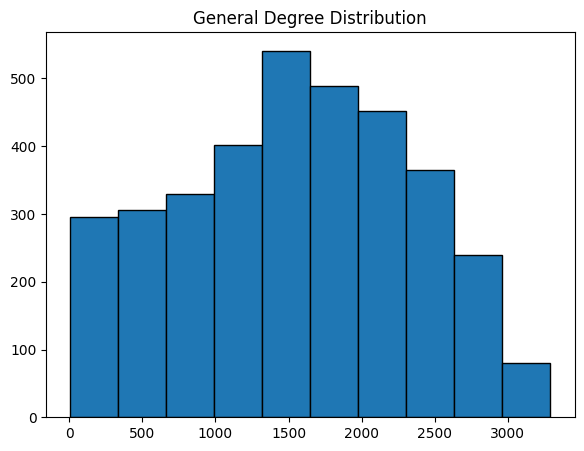

In [42]:
fig = plt.figure(figsize=(15,5))

#General degree distribution
plt.subplot(1, 2, 1)
plt.title("General Degree Distribution")
degrees = [d for n,d in player_projected_graph.degree()]
plt.hist([d for n,d in player_projected_graph.degree()], edgecolor = 'black' )

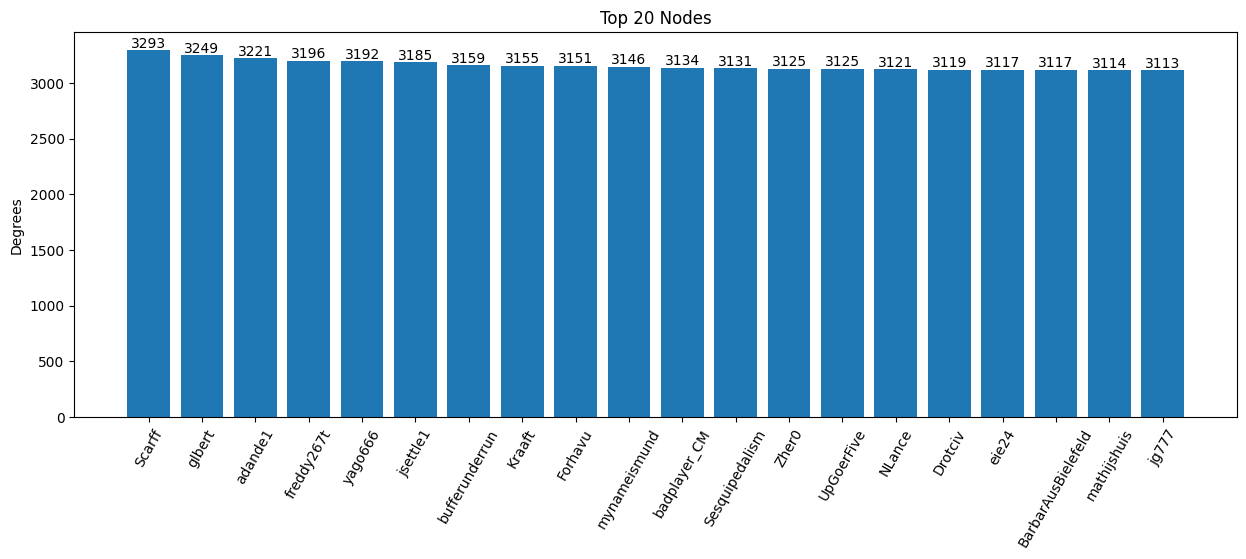

In [43]:
#Degree distribution of network top 20
nodeDegrees = [(n,d) for n,d in player_projected_graph.degree()]
nodeDegrees.sort(key = lambda x: x[1], reverse=True)
degrees = [d for n,d in nodeDegrees[:20]]
labels = [n for n,d in nodeDegrees[:20]]

fig, ax = plt.subplots(figsize=(15, 5))
bar_container = ax.bar(labels, degrees)
ax.set(ylabel='Degrees', title='Top 20 Nodes')
ax.bar_label(bar_container)
plt.xticks(rotation=60)
fig.show()

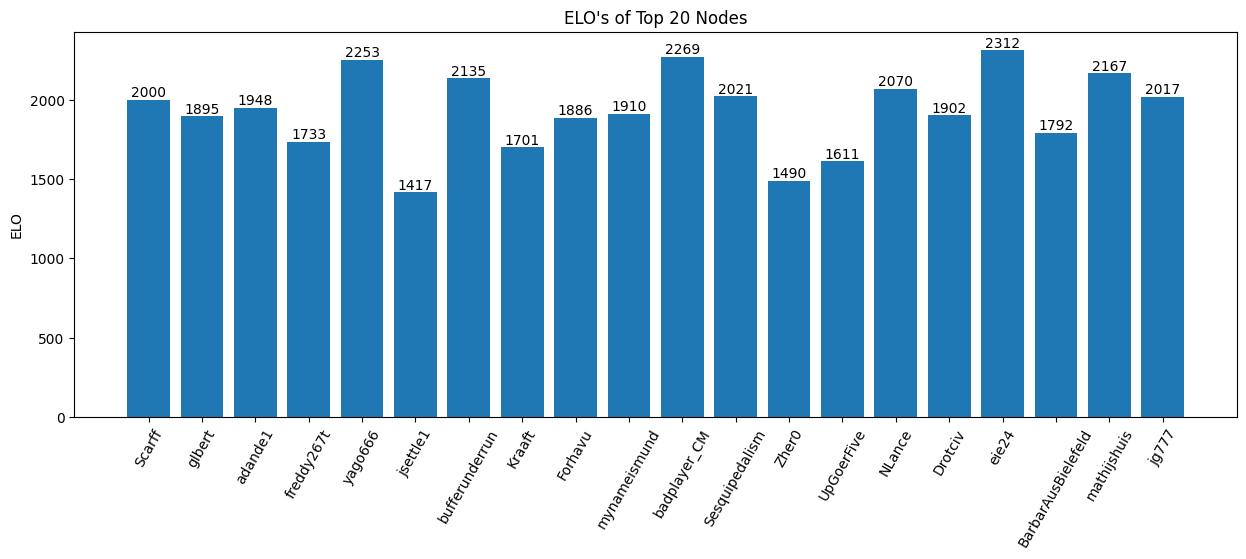

In [44]:
#ELO distribution of network Top 20 (by nodes)
nodeDegrees = [(n,d) for n,d in player_projected_graph.degree()]
nodeDegrees.sort(key = lambda x: x[1], reverse=True)
labels = [n for n,d in nodeDegrees[:20]]
elos = []

for n in labels:
  elos.append( player_projected_graph.nodes(data=True)[n]['elo'] )

fig, ax = plt.subplots(figsize=(15, 5))
bar_container = ax.bar(labels, elos)
ax.set(ylabel='ELO', title="ELO's of Top 20 Nodes")
ax.bar_label(bar_container)
plt.xticks(rotation=60)
fig.show()

In [50]:
#Clustering and density analysis of network
#print("Average clustering of network: ", nx.average_clustering(player_projected_graph))
print(f"Density of network: {nx.density(player_projected_graph)}\n")

# clusteringCoefficients = list(nx.clustering(player_projected_graph).items())
# clusteringCoefficients.sort(key = lambda i:i[1], reverse = True)
# labels = [n for n,c in clusteringCoefficients[:20]]
# coefficients = [c for n,c in clusteringCoefficients[:20]]

# fig, ax = plt.subplots(figsize=(15, 5))
# bar_container = ax.bar(labels, coefficients)
# ax.set(ylabel='Clustering Coefficients', title='Clustering Coefficient Top 20 Nodes')
# ax.bar_label(bar_container, fmt='{:,.4f}')
# plt.xticks(rotation=60)
# fig.show()

Density of network: 0.442853165165012



Degree assortativity of network: -0.18480861810394758

Degree pearson correlation coefficient of graph: -0.18480861810386395

Average degree connectivity of graph: {1414: 2047.490099009901, 2206: 1916.814445451798, 729: 2202.2482853223596, 1223: 2077.8928863450533, 1634: 2027.2680538555692, 1788: 1981.0399888143177, 1328: 2069.0027108433733, 2374: 1879.4589300758214, 2017: 1964.2553296975707, 1681: 2045.195915129883, 2250: 1899.6835555555556, 1573: 2033.3129900402628, 1868: 1982.4670770877945, 1605: 2037.3059190031154, 941: 2138.1948281969535, 1462: 2066.5389876880986, 1910: 1985.6119109947645, 1226: 2074.8097471451874, 2618: 1820.8318054494525, 643: 2152.933125972006, 144: 2213.9953703703704, 1794: 1990.3821070234114, 2032: 1956.8056102362204, 1430: 2079.846153846154, 1836: 1979.8096405228757, 1248: 2068.387019230769, 902: 2076.172949002217, 1526: 2001.9711664482306, 868: 2179.8905529953918, 1525: 2031.7718032786886, 2934: 1741.3319700068166, 875: 2190.416, 2170: 1911.8419354838709, 1

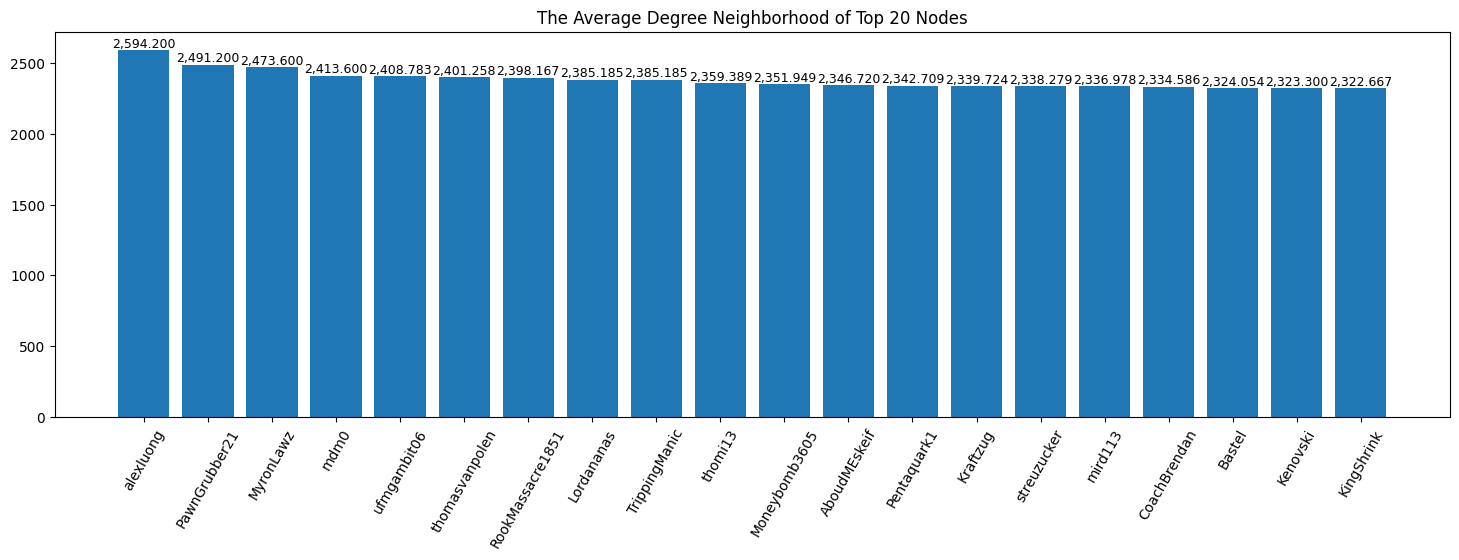

In [45]:
#Assortativeness analysis of network
print(f"Degree assortativity of network: {nx.degree_assortativity_coefficient(player_projected_graph)}\n")
print(f"Degree pearson correlation coefficient of graph: {nx.degree_pearson_correlation_coefficient(player_projected_graph)}\n")

#Degree connectivity of network
print(f"Average degree connectivity of graph: {nx.average_degree_connectivity(player_projected_graph)}\n")

#Average neighbor degree of network
nodesNeighborDegree = list(nx.average_neighbor_degree(player_projected_graph).items())
nodesNeighborDegree.sort(key = lambda i:i[1], reverse = True)
labels = [n for n,c in nodesNeighborDegree[:20]]
coefficients = [c for n,c in nodesNeighborDegree[:20]]

fig, ax = plt.subplots(figsize=(18, 5))
bar_container = ax.bar(labels, coefficients)
ax.set( title='The Average Degree Neighborhood of Top 20 Nodes')
ax.bar_label(bar_container, fmt='{:,.3f}', fontsize = 9)
plt.xticks(rotation=60)
fig.show()